In [ ]:
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

from PIL import Image
from models import get_models
model_cls = get_models("qwen2_5_vl", logger)
model = model_cls(config={})

    # Prepare the input data
image_paths = [
    "./data/0b22fa63d0f54a529c525afbf2e8bb25_0.png",
    "./data/0b22fa63d0f54a529c525afbf2e8bb25_1.png",
    "./data/0b22fa63d0f54a529c525afbf2e8bb25_2.png",
    "./data/0b22fa63d0f54a529c525afbf2e8bb25_3.png",
]
images = []
for path in image_paths:
    try:
        img = Image.open(path).convert("RGB")
        images.append(img)
    except FileNotFoundError:
        logger.error(f"Image file not found: {path}")
        exit()

input_data = {
    "views": images,
    "instruction": "Describe the scene in detail."
}
prompt = "{image} {instruction}"

output = model(prompt, input_data)

print(output)

print("done")

In [1]:
from tasks.feature_db import ImageObservationDB

image_obs_dir = "../data/marked_obs"
caption_dir = "../data/MP3D/GPT-4o_caption.json"
scan = "1LXtFkjw3qL"
viewpoint_id = "0b22fa63d0f54a529c525afbf2e8bb25"

obs = ImageObservationDB(image_obs_dir, caption_dir, None, None)

ob = obs.get_image_observation(scan, viewpoint_id)

/root/miniconda3/envs/navgpt/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ob

{'img_obs': {'left': <PIL.Image.Image image mode=RGB size=256x256>,
  'front': <PIL.Image.Image image mode=RGB size=256x256>,
  'right': <PIL.Image.Image image mode=RGB size=256x256>,
  'back': <PIL.Image.Image image mode=RGB size=256x256>},
 'caption': {'1': 'Wooden pathway with a modern overhang; leads toward an outdoor area with decorative elements.',
  '2': 'Hallway with tiled flooring and potted plants; leads toward an interior space with glass partitions.'},
 'summary': None,
 'map': None}

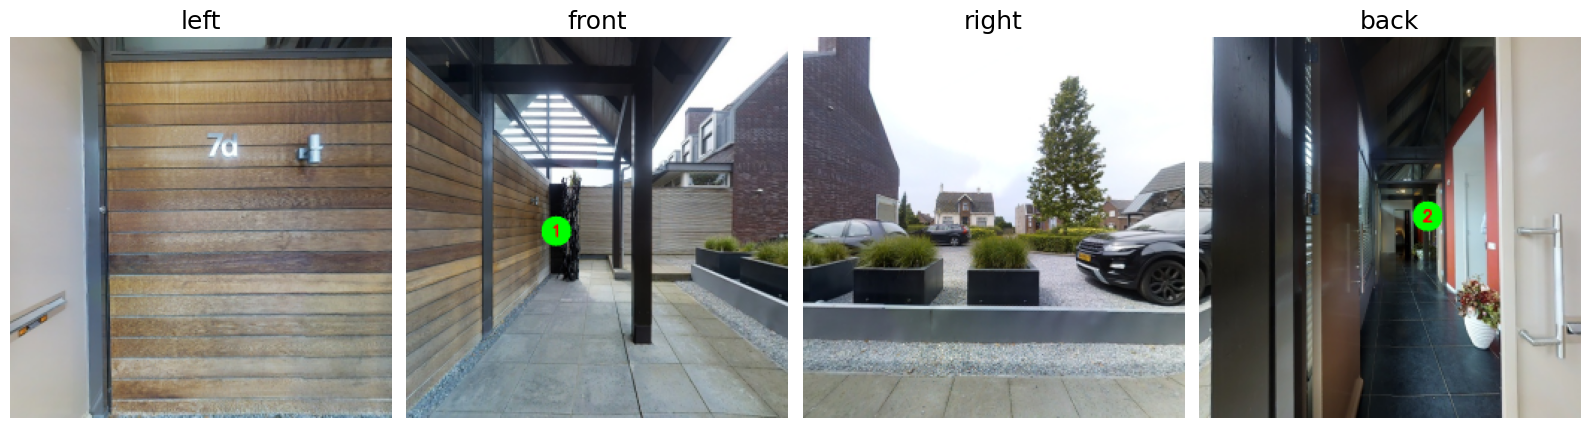

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

def display_four_images(img_obs):
    # Create a figure and a set of subplots
    fig, axes = plt.subplots(1, 4, figsize=(16, 8)) # figsize (width, height) in inches

    # Iterate through the images and display them
    for i, (direction, img) in enumerate(img_obs.items()):
        if img is not None and isinstance(img, Image.Image):
            axes[i].imshow(img)
            axes[i].set_title(direction, fontsize=18) # Get title or default
            axes[i].axis('off') # Hide axes ticks and labels for cleaner display

    plt.tight_layout() # Adjust subplot params for a tight layout
    plt.show()

# Call the function with the 'img_obs' part of your dictionary
display_four_images(ob['img_obs'])

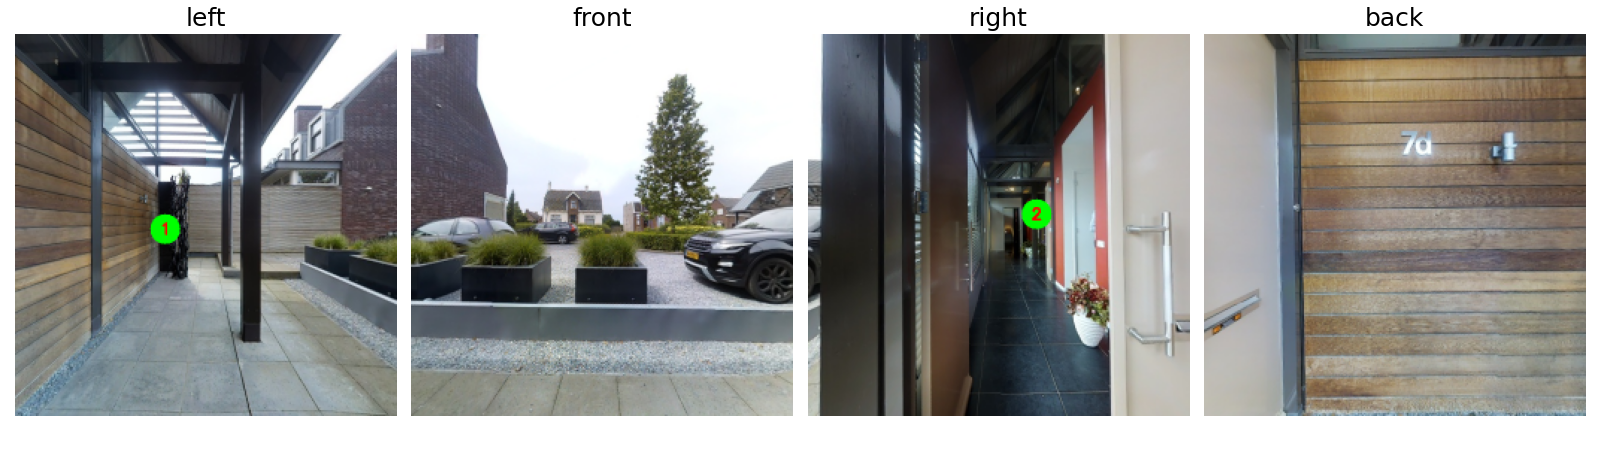

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
import io

def display_four_images_with_heading(img_obs, heading_deg=0):
    # Normalize heading to be within 0 to 359 degrees
    normalized_heading = heading_deg % 360
    if normalized_heading < 0:
        normalized_heading += 360

    if (normalized_heading >= 315 and normalized_heading < 360) or \
       (normalized_heading >= 0 and normalized_heading < 45):
        current_front_key = 'front'
        global_front_deg = 0
    elif normalized_heading >= 45 and normalized_heading < 135:
        current_front_key = 'right'
        global_front_deg = 90
    elif normalized_heading >= 135 and normalized_heading < 225:
        current_front_key = 'back'
        global_front_deg = 180
    elif normalized_heading >= 225 and normalized_heading < 315:
        current_front_key = 'left'
        global_front_deg = 270
    else:
        current_front_key = 'front'
        global_front_deg = 0
        print(f"Warning: Could not determine current front based on heading {heading_deg}. Defaulting to 'front'.")

    global_order_keys = ['left', 'front', 'right', 'back']
    idx_current_front = global_order_keys.index(current_front_key)

    display_keys = [
        global_order_keys[(idx_current_front - 1 + 4) % 4], # Agent's Left
        global_order_keys[idx_current_front],               # Agent's Front
        global_order_keys[(idx_current_front + 1) % 4],     # Agent's Right
        global_order_keys[(idx_current_front + 2) % 4]      # Agent's Back
    ]

    TITLE_FONT_SIZE = 18
    fig, axes = plt.subplots(1, 4, figsize=(16, 4.5))

    for i, key_to_display in enumerate(display_keys):
        img_to_show = img_obs.get(key_to_display)

        if img_to_show is not None and isinstance(img_to_show, Image.Image):
            axes[i].imshow(img_to_show)
            axes[i].set_title(global_order_keys[i], fontsize=TITLE_FONT_SIZE)
            axes[i].axis('off')
        else:
            print(f"Warning: Image for global '{key_to_display}' is missing or not a PIL Image object.")
            axes[i].set_title(f'No {global_order_keys[i]} Image', fontsize=TITLE_FONT_SIZE)
            axes[i].axis('off')

    # Save the plot to a buffer
    buf = io.BytesIO()
    plt.tight_layout()
    plt.savefig(buf, format='png')
    plt.close(fig)  # Close the figure to free memory
    buf.seek(0)

    # Convert buffer to PIL Image
    img_result = Image.open(buf)
    return img_result

display_four_images_with_heading(ob['img_obs'], 46)
